In [6]:
import sys; sys.path.append('..')
from utils import *
from mvtecad_test import *
from anomaly_twin_imagelist import *
from fastai.callbacks import SaveModelCallback
import warnings
warnings.filterwarnings('ignore')

# Data Augmentation

In [7]:
folder_path = os.path.abspath('./dataset/pill/train/good')
tfms_trn, tfms_val = get_transforms(do_flip=False)
tfms = (tfms_trn[:-1].append(crop_pad(padding_mode='zeros')), tfms_val)
anomaly_data = AnomalyTwinImageList.databunch(folder_path, size=224, tfms=tfms)

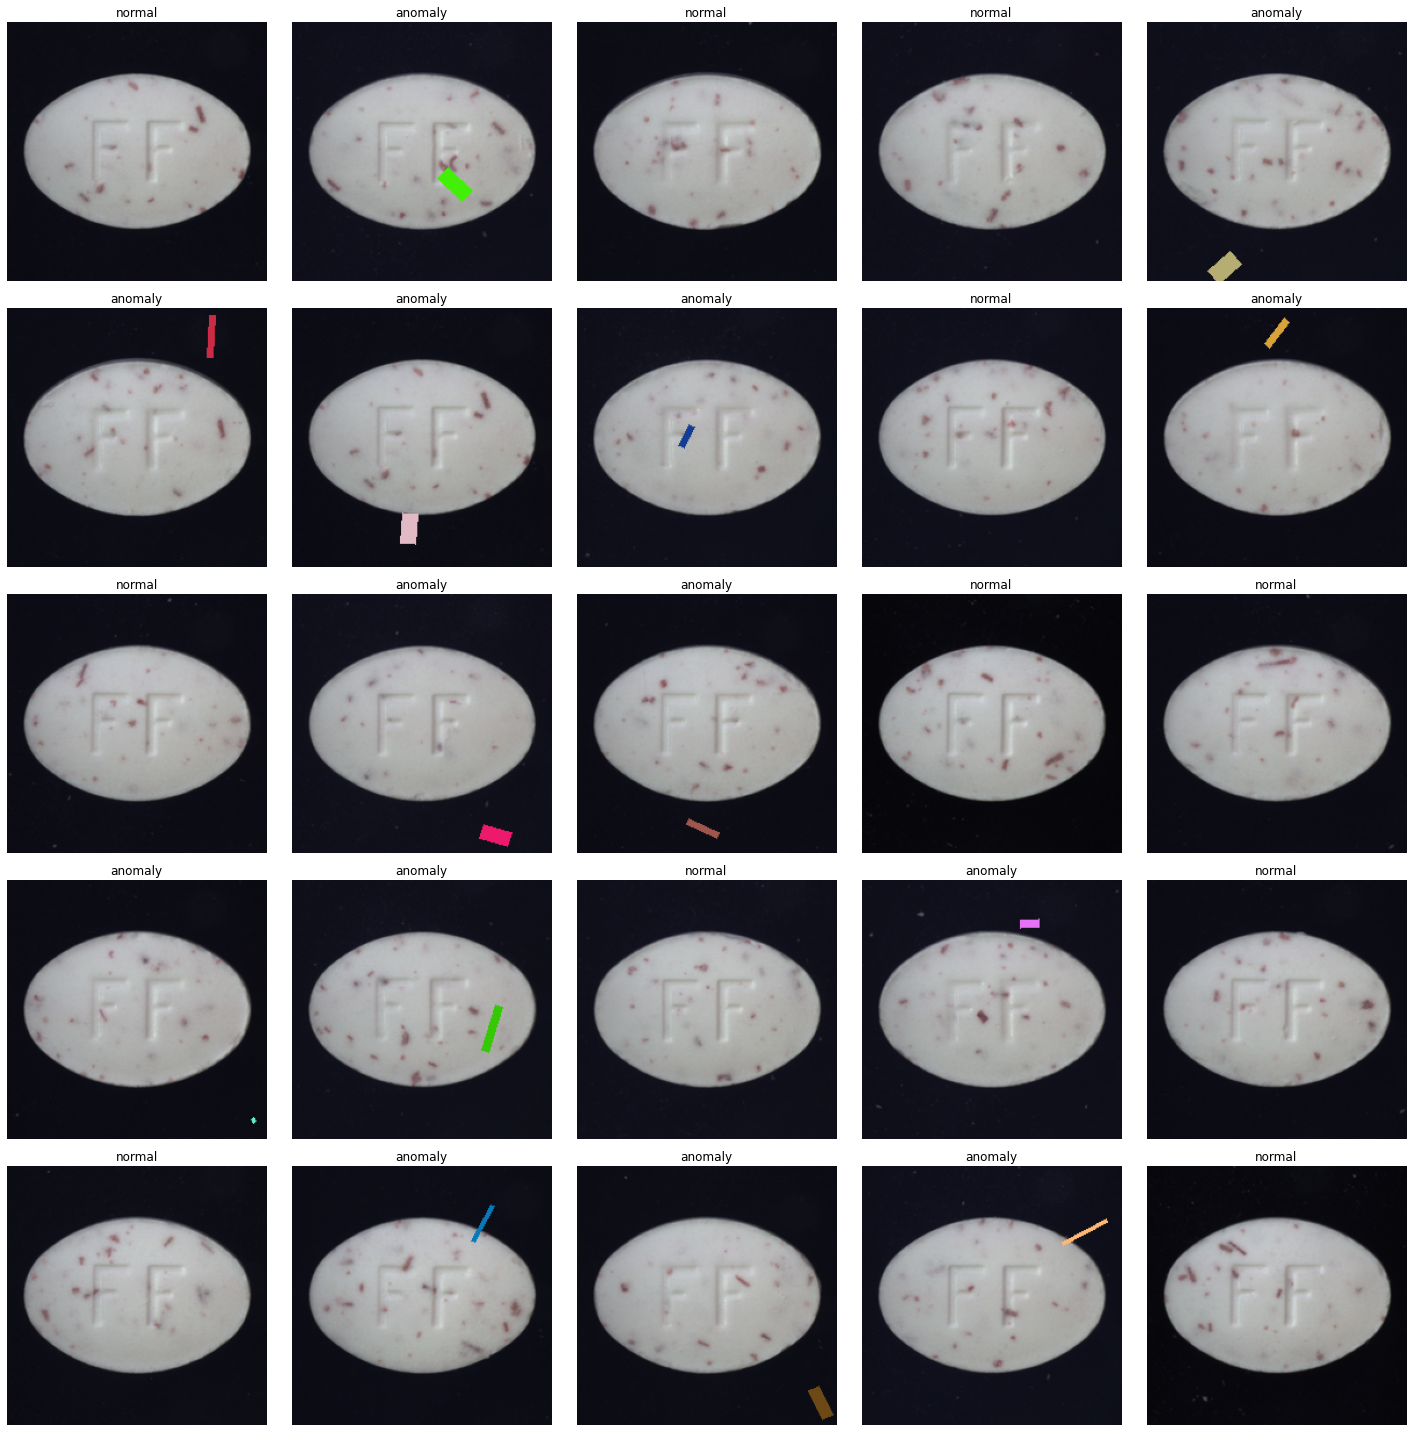

In [8]:
anomaly_data.show_batch()

# Training

## 1. Conventional CNN

In [52]:
def learner_conventional(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy).mixup()
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [53]:
learn_conventional = learner_conventional(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,1.018539,1.031202,0.500000,00:08
1,0.892300,0.587036,0.745283,00:08
2,0.796013,0.680609,0.698113,00:08
3,0.743139,0.585646,0.735849,00:08
4,0.698128,0.599084,0.726415,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.516115,0.712824,0.726415,00:08
1,0.570516,3.286593,0.490566,00:08
2,0.558982,0.174239,0.924528,00:08
3,0.527550,0.320097,0.905660,00:08
4,0.499350,0.159828,0.905660,00:08


Better model found at epoch 0 with valid_loss value: 0.7128238081932068.
Better model found at epoch 2 with valid_loss value: 0.17423908412456512.
Better model found at epoch 4 with valid_loss value: 0.15982754528522491.


epoch,train_loss,valid_loss,accuracy,time
0,0.407668,0.135288,0.981132,00:08
1,0.421998,0.251319,0.905660,00:08
2,0.435108,0.085671,0.981132,00:08
3,0.409077,0.038056,0.990566,00:08
4,0.392999,0.073350,0.981132,00:08


Better model found at epoch 0 with valid_loss value: 0.13528825342655182.
Better model found at epoch 2 with valid_loss value: 0.08567141741514206.
Better model found at epoch 3 with valid_loss value: 0.03805616497993469.


In [54]:
learn_conventional.export(os.path.abspath('./models/export_conventional.pkl'))

## 2. L2 Constrained

In [56]:
def learner_L2ConstrainedNet(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy).mixup()
    learn.model = L2ConstrainedNet(learn.model)
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [57]:
learn_l2constrained = learner_L2ConstrainedNet(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,0.905766,0.935365,0.500000,00:08
1,0.648039,0.592752,0.575472,00:08
2,0.548885,0.509997,0.679245,00:08
3,0.495153,0.437650,0.716981,00:08
4,0.465385,0.387549,0.783019,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.358126,0.647726,0.528302,00:08
1,0.334114,1.022208,0.500000,00:08
2,0.318877,1.340715,0.500000,00:08
3,0.303414,1.172247,0.500000,00:08
4,0.295154,0.443092,0.726415,00:08


Better model found at epoch 0 with valid_loss value: 0.6477263569831848.
Better model found at epoch 4 with valid_loss value: 0.4430919289588928.


epoch,train_loss,valid_loss,accuracy,time
0,0.273416,0.170010,0.990566,00:08
1,0.276235,0.910993,0.500000,00:08
2,0.272119,0.097658,1.000000,00:08
3,0.270583,0.083204,0.990566,00:08
4,0.270430,0.079751,0.990566,00:08


Better model found at epoch 0 with valid_loss value: 0.17001014947891235.
Better model found at epoch 2 with valid_loss value: 0.097658172249794.
Better model found at epoch 3 with valid_loss value: 0.08320444822311401.
Better model found at epoch 4 with valid_loss value: 0.07975132018327713.


In [58]:
learn_l2constrained.export(os.path.abspath('./models/export_l2constrained.pkl'))

## 3.ArcFace

In [59]:
def learner_ArcFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, ArcMarginProduct, m=0.5)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [60]:
learn_arcface = learner_ArcFace(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,13.354247,5.172238,0.500000,00:08
1,9.337343,0.840951,0.858491,00:08
2,6.875423,0.802323,0.811321,00:08
3,5.445856,0.674996,0.792453,00:08
4,4.668565,0.687112,0.886792,00:08


epoch,train_loss,valid_loss,accuracy,time
0,2.079520,0.414933,0.905660,00:08
1,1.749750,4.430198,0.556604,00:08
2,1.166012,2.219348,0.613208,00:08
3,0.882894,0.001180,1.000000,00:08
4,0.770389,0.175917,0.990566,00:08


Better model found at epoch 0 with valid_loss value: 0.4149329662322998.
Better model found at epoch 3 with valid_loss value: 0.0011795703321695328.


epoch,train_loss,valid_loss,accuracy,time
0,0.299899,0.331641,0.990566,00:08
1,0.355541,0.269016,0.990566,00:08
2,0.473276,0.234181,0.990566,00:08
3,0.463767,0.896958,0.971698,00:08
4,0.391476,0.414504,0.990566,00:08


Better model found at epoch 0 with valid_loss value: 0.33164075016975403.
Better model found at epoch 1 with valid_loss value: 0.269016295671463.
Better model found at epoch 2 with valid_loss value: 0.23418129980564117.


In [61]:
learn_arcface.export(os.path.abspath('./models/export_arcface.pkl'))

## 4.CosFace

In [62]:
def learner_CosFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, AddMarginProduct, m=0.4)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [63]:
learn_cosface = learner_CosFace(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,11.323424,3.292598,0.500000,00:08
1,7.707921,0.440266,0.811321,00:08
2,5.577461,1.722973,0.660377,00:08
3,4.347927,1.648656,0.660377,00:08
4,3.613166,1.026298,0.735849,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.325337,0.451401,0.924528,00:08
1,1.269207,0.083293,0.971698,00:08
2,1.038803,0.131023,0.981132,00:08
3,0.770096,0.000035,1.000000,00:08
4,0.609272,0.000011,1.000000,00:08


Better model found at epoch 0 with valid_loss value: 0.4514014720916748.
Better model found at epoch 1 with valid_loss value: 0.083293117582798.
Better model found at epoch 3 with valid_loss value: 3.490554809104651e-05.
Better model found at epoch 4 with valid_loss value: 1.1254624951106962e-05.


epoch,train_loss,valid_loss,accuracy,time
0,0.148970,0.000000,1.000000,00:08
1,0.144351,0.000874,1.000000,00:08
2,0.127509,0.000117,1.000000,00:08
3,0.203199,0.394148,0.990566,00:08
4,0.199370,0.000000,1.000000,00:08


Better model found at epoch 0 with valid_loss value: 1.7431524668154452e-07.
Better model found at epoch 4 with valid_loss value: 9.67169384580302e-08.


In [64]:
learn_cosface.export(os.path.abspath('./models/export_cosface.pkl'))

## 5. SphereFace

In [65]:
def learner_SphereFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, SphereProduct, m=int(4))
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [66]:
learn_sphereface = learner_SphereFace(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,0.932803,0.580204,0.707547,00:08
1,0.624643,1.322195,0.575472,00:08
2,0.498409,1.821795,0.556604,00:08
3,0.438735,1.570800,0.575472,00:08
4,0.379405,0.964038,0.698113,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.393575,0.729647,0.698113,00:07
1,0.341841,9.982864,0.500000,00:07
2,0.286422,8.137610,0.500000,00:07
3,0.225705,3.568042,0.500000,00:08
4,0.187133,0.080448,0.990566,00:08


Better model found at epoch 0 with valid_loss value: 0.7296472191810608.
Better model found at epoch 4 with valid_loss value: 0.08044803142547607.


epoch,train_loss,valid_loss,accuracy,time
0,0.123673,0.068762,0.962264,00:08
1,0.112438,0.002803,1.000000,00:08
2,0.118074,0.217873,0.971698,00:08
3,0.100566,0.001150,1.000000,00:08
4,0.082746,0.109105,0.990566,00:08


Better model found at epoch 0 with valid_loss value: 0.06876159459352493.
Better model found at epoch 1 with valid_loss value: 0.0028029901441186666.
Better model found at epoch 3 with valid_loss value: 0.0011499368119984865.


In [67]:
learn_sphereface.export(os.path.abspath('./models/export_sphereface.pkl'))

## 6.CenterLoss

In [68]:
def learner_CenterLoss(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.loss_func = WrapCenterLoss(learn, train_data, weight_cent=1/8)
    learn.fit_one_cycle(5)
    learn.unfreeze()
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn)])
    return learn

In [69]:
learn_centerloss = learner_CenterLoss(anomaly_data)

epoch,train_loss,valid_loss,accuracy,time
0,1.966182,0.821027,0.650943,00:08
1,1.954416,1.102233,0.650943,00:07
2,1.878286,1.387178,0.641509,00:08
3,1.822203,1.143546,0.707547,00:08
4,1.725086,0.986009,0.707547,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.469562,0.977744,0.716981,00:08
1,1.477600,1.138985,0.622642,00:08
2,1.384554,2.101745,0.452830,00:08
3,1.340028,1.117430,0.603774,00:08
4,1.279399,0.644824,0.952830,00:08


Better model found at epoch 0 with valid_loss value: 0.9777444005012512.
Better model found at epoch 4 with valid_loss value: 0.6448243856430054.


epoch,train_loss,valid_loss,accuracy,time
0,1.057306,0.666751,0.858491,00:08
1,0.979076,0.652804,0.952830,00:08
2,0.922215,0.649144,0.981132,00:08
3,0.874029,0.533153,0.915094,00:08
4,0.844245,0.474051,0.943396,00:08


Better model found at epoch 0 with valid_loss value: 0.6667512655258179.
Better model found at epoch 1 with valid_loss value: 0.6528040766716003.
Better model found at epoch 2 with valid_loss value: 0.6491442918777466.
Better model found at epoch 3 with valid_loss value: 0.5331532955169678.
Better model found at epoch 4 with valid_loss value: 0.4740510880947113.


In [70]:
learn_centerloss.export(os.path.abspath('./models/export_centerloss.pkl'))

# Evaluation

In [77]:
def get_roc_auc(learn, distance_method='cosine', save_train_embs=False, train_emb_filename=''):
    test_path = os.path.abspath('./dataset/pill/test')
    eval_test_ds, eval_test_dl = prepare_subset_ds_dl(test_path, size=1.0, tfms=None, img_size=224)
    eval_train_ds, eval_train_dl = prepare_subset_ds_dl(learn.data.train_ds.path, size=1.0, tfms=None, img_size=224)
    test_embs,  test_y  = get_embeddings(body_feature_model(learn.model), eval_test_dl, return_y=True)
    train_embs, train_y = get_embeddings(body_feature_model(learn.model), eval_train_dl, return_y=True)
    if save_train_embs:
        torch.save(train_embs, train_emb_filename)

    distances = n_by_m_distances(test_embs, train_embs, how=distance_method)
    preds = np.min(distances, axis=1)

    test_anomaly_mask = [y != eval_test_ds.classes.index('good') for y in test_y]
    y_true = np.array(list(map(int, test_anomaly_mask)))

    fpr, tpr, thresholds = metrics.roc_curve(y_true, preds)
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, auc

def get_optimal_threshold(fpr, tpr, thresholds):
    tpr_tnr = np.vstack([tpr, 1-fpr])
    optimal_idx = np.argmax(np.sum(tpr_tnr, axis=0))
    return thresholds[optimal_idx]

def plot_roc_curve(fpr, tpr, title):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}: ROC Curve')
    plt.legend()
    plt.show()

In [72]:
models = {
    'conventional': learn_conventional,
    'l2constrained': learn_l2constrained,
    'arcface': learn_arcface,
    'cosface': learn_cosface,
    'sphereface': learn_sphereface,
    'centerloss': learn_centerloss
}

conventional: auc: 0.8112384069830877, optimal threshold: 0.18666386604309082


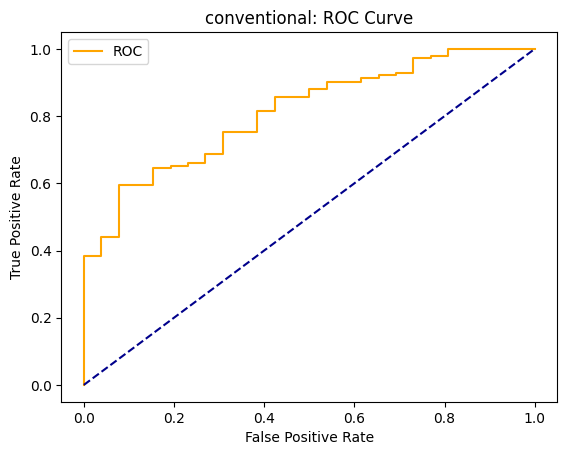

l2constrained: auc: 0.6723949809056192, optimal threshold: 5.960464477539063e-08


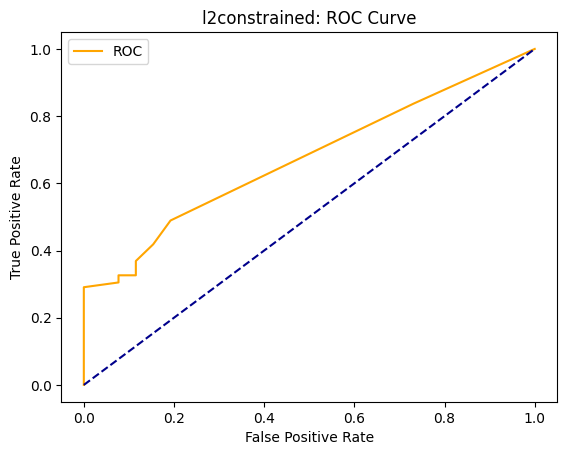

arcface: auc: 0.759683578832515, optimal threshold: 0.01610720157623291


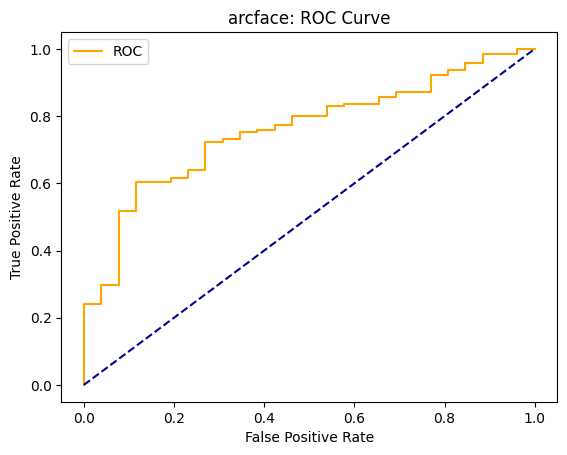

cosface: auc: 0.8390616475722857, optimal threshold: 0.01686614751815796


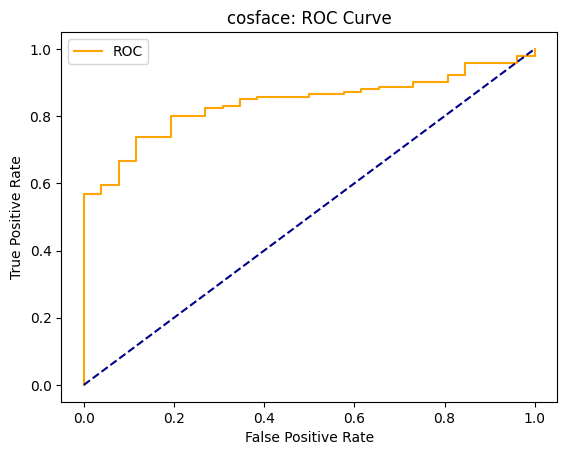

sphereface: auc: 0.7839607201309329, optimal threshold: 0.10420072078704834


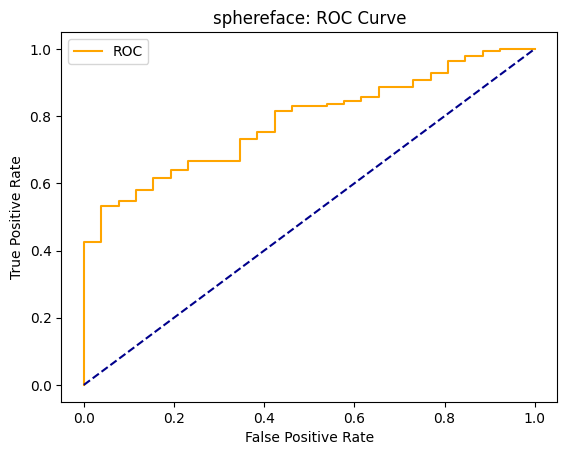

centerloss: auc: 0.8573376977632297, optimal threshold: 0.14739567041397095


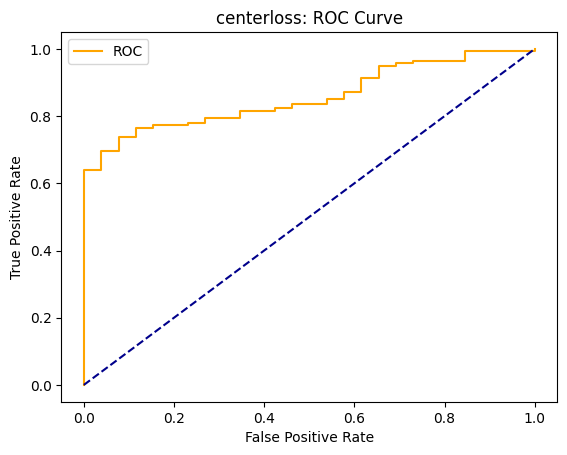

In [78]:
for title, model in models.items():
    fpr, tpr, thresholds, auc = get_roc_auc(model, save_train_embs=True, train_emb_filename=f"train_embs_{title}.pt")
    optim_threshold = get_optimal_threshold(fpr, tpr, thresholds)
    print(f"{title}: auc: {auc}, optimal threshold: {optim_threshold}")
    plot_roc_curve(fpr, tpr, title)
